In [2]:
!pip install altair

     |████████████████████████████████| 737kB 3.6MB/s eta 0:00:01


In [7]:
pip install altair vega_datasets

     |████████████████████████████████| 215kB 3.5MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import seaborn as sns
sns.set_style('whitegrid')
import altair as alt
import altair as alt
#if you are working in a notebook environment, you'll need the below line as altair wouldn't display the chart 
#unless it evaluates the below statement. 
#As different systems/environment ha sdifferent requirements and constraints we have function to do all the 
#essential environment settings on its own. Pretty neat huh!
#it is supposed to work fine wihtout the below line. Let's see
#alt.renderers.enable("notebook")
#code for hiding seaborn warning
import warnings
warnings.filterwarnings("ignore")

In [11]:
df = pd.read_csv("News_dataset.csv", sep=';', header=None)

Got an error when executing : df = pd.read_csv("News_dataset.csv"). In the code above, sep defines your delimiter and header=None tells pandas that your source data has no row for headers / column titles. Thus saith the docs: "If file contains no header row, then you should explicitly pass header=None". In this instance, pandas automatically creates whole-number indices for each field {0,1,2,...}. According to the docs, the delimiter thing should not be an issue. The docs say that "if sep is None [not specified], will try to automatically determine this." I however have not had good luck with this, including instances with obvious delimiters.

In [12]:
df.head()

,0,1,2,3
0,File_Name,Content,Category,Complete_Filename
1,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business
2,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business
3,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business
4,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business


In [13]:
#replacing header with row 0
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

In [14]:
df.head()

,File_Name,Content,Category,Complete_Filename
1,001.txt,Ad sales boost Time Warner profit\n\nQuarterly...,business,001.txt-business
2,002.txt,Dollar gains on Greenspan speech\n\nThe dollar...,business,002.txt-business
3,003.txt,Yukos unit buyer faces loan claim\n\nThe owner...,business,003.txt-business
4,004.txt,High fuel prices hit BA's profits\n\nBritish A...,business,004.txt-business
5,005.txt,Pernod takeover talk lifts Domecq\n\nShares in...,business,005.txt-business


#### Number of articles in each category

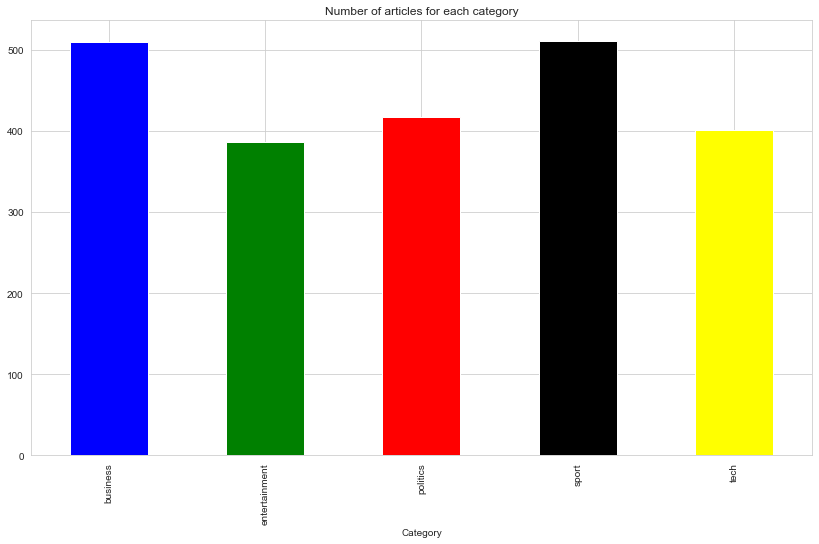

In [36]:
df_bar = df.groupby('Category')['File_Name'].count()
df_bar.plot.bar(title="Number of articles for each category", figsize=(14,8),color = ['blue', 'green','red','black','yellow'])
#df_bar.plot(kind='bar', stacked=True)

#### Number of articles in each category

In [65]:
df_per=pd.DataFrame(df_bar)
df_per['Percent']= (df_per['File_Name']/df_per['File_Name'].sum())#*100
df_per.reset_index(level=0, inplace=True)
df_per

,Category,File_Name,Percent
0,business,510,0.229213
1,entertainment,386,0.173483
2,politics,417,0.187416
3,sport,511,0.229663
4,tech,401,0.180225


In [67]:
bars = alt.Chart(df_per).mark_bar(size=50).encode(
    x=alt.X('Category'),
    y=alt.Y('Percent',axis=alt.Axis(format='.0%', title='% of Articles')), color='Category'
)
text = bars.mark_text(align='center', baseline='bottom').encode(text=alt.Text('Percent', format='.1%'))
(bars + text).interactive().properties(
    height=300, 
    width=700,
    title = "% of articles in each category",
)

alt.LayerChart(...)

The classes are approximately balanced. We'll first try to train the models without oversampling/undersampling. If we see some bias in the model, we'll use these techniques.

### News length by category

Even though the content has some special characters, let's plot the news length distribution

In [68]:
df['News_length']=df['Content'].str.len()

Text(0.5, 1.0, 'News Length Distribution')

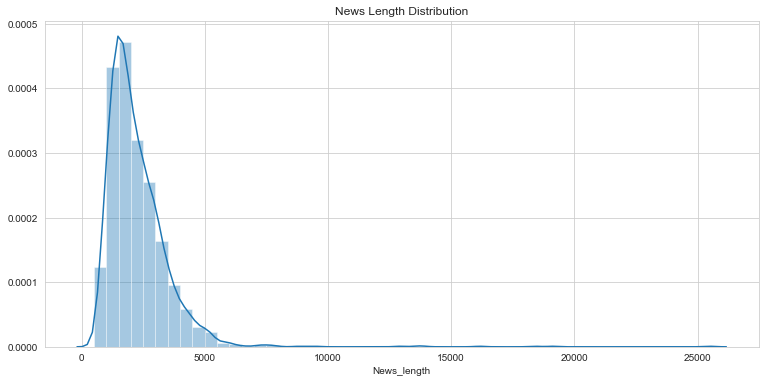

In [69]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['News_length']).set_title('News Length Distribution')

In [73]:
df['News_length'].describe()

count     2225.000000
mean      2264.790562
std       1364.305951
min        502.000000
25%       1447.000000
50%       1966.000000
75%       2803.000000
max      25484.000000
Name: News_length, dtype: float64

As the length of 2803 seems to cover 75 percentile and from the histogram we can see that about 95 percentile of data lies within 5000 characters. Let's remove everything about 95% to better appreciate our histogram

In [74]:
percentile_95 = df['News_length'].quantile(0.95)
df_95 = df[df['News_length'] < percentile_95]

Text(0.5, 1.0, 'News Length Distribution')

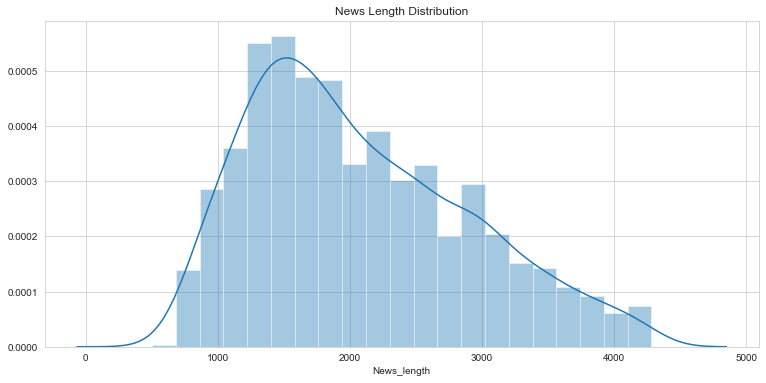

In [75]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['News_length']).set_title('News Length Distribution')

Our dataset within 95 percentile is just a shy of 5000 characters. Let's count the number of articles above this quantile. And then count articles above 1000 characters

In [77]:
len(df[df['News_length'] > percentile_95]) #Number of articles that have characters more than the 95 percentile

112

In [79]:
print("Number of article ")
print("> 5000 characters:"+str(len(df[df['News_length'] > 5000])))
print("> 10000 characters:"+str(len(df[df['News_length'] > 10000])))
print("> 15000 characters:"+str(len(df[df['News_length'] > 15000])))
print("> 20000 characters:"+str(len(df[df['News_length'] > 20000])))
print("> 25000 characters:"+str(len(df[df['News_length'] > 25000])))

Number of article 
> 5000 characters:53
> 10000 characters:7
> 15000 characters:4
> 20000 characters:1
> 25000 characters:1


Removing 65 articles from 2200+ articles might not affect our training. Let's remove these and visualise any outliers with box plot

Text(0.5, 1.0, 'News Length per category: Before removing large documents')

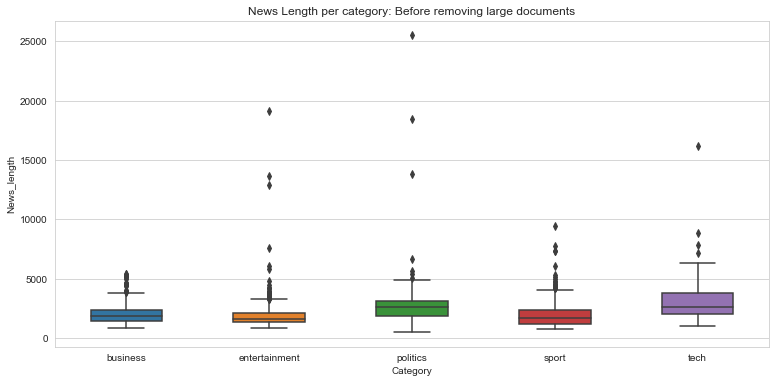

In [82]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='Category', y='News_length', width=.5).set_title('News Length per category: Before removing large documents')

Let's plot the df_95 dataframe as it contains articles withing the 95 percentile range of characters

Text(0.5, 1.0, 'News Length per category: After removing large documents')

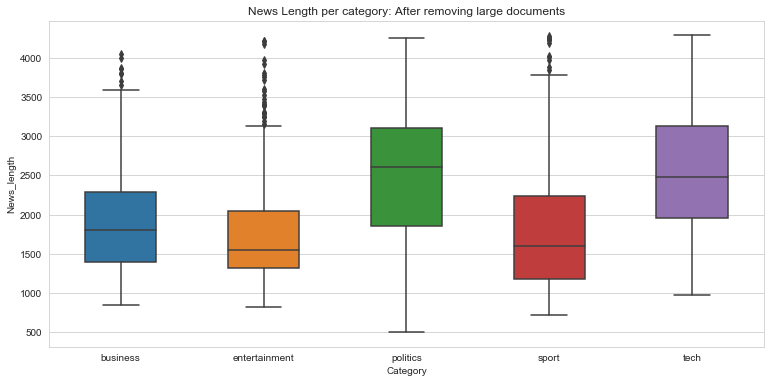

In [83]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='Category',y='News_length', width=0.5).set_title('News Length per category: After removing large documents')

We can see that, although the length distribution is different for every category, the difference is not too big. If we had way too different lengths between categories we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.

At this point, we cannot do further Exploratory Data Analysis. We'll turn onto the Feature Engineering section.

We'll save the dataset:

In [84]:
with open("News_dataset.pickle",'wb') as output:
    pickle.dump(df_95,output)